In [12]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator

from dataclasses import dataclass
import platform

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    
#     physical_devices = tf.config.list_physical_devices("GPU")
#     try:
#         tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     except:
#         # Invalid device or cannot modify virtual devices once initialized.
#         pass

    return

set_seeds()

In [3]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

In [4]:
# Printing the number of devices that are in sync with the MirroredStrategy.
# This indicates how many replicas of the model are being trained in parallel.
print('Number of devices: {}'.format(DISTRIBUTE_STRATEGY.num_replicas_in_sync))

Number of devices: 2


**Set Data Paths**

In [5]:

root_dir = r"../input/opencv-TF-course-project-1-image-classification/dataset"

train_dir = os.path.join(root_dir, "Train")
valid_dir = os.path.join(root_dir, "Valid")

In [6]:
def list_folders(startpath):
    for root, _, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root):<8}')


list_folders(root_dir)

dataset 
    Valid   
        spider  
        horse   
        elephant
        cow     
    Test    
    Train   
        spider  
        horse   
        elephant
        cow     


In [7]:
print(f"{bold}Training Classes:{end} ")
for i in os.listdir(train_dir):
    print(i)
    
print("------------")

print(f"{bold}Validation Classes:{end} ")
for j in os.listdir(valid_dir):
    print(j)

Training Classes: 
spider
horse
elephant
cow
------------
Validation Classes: 
spider
horse
elephant
cow


In [8]:
num_train_files = 0
num_valid_files = 0


for subdir,dirs,files in os.walk(train_dir):
    num_train_files += len(files)
for subdir,dirs,files in os.walk(valid_dir):
    num_valid_files += len(files)


print(f"{bold}Number of Training samples: {end}{num_train_files}")
print(f"{bold}Number of Validation samples: {end}{num_valid_files}")

Number of Training samples: 3997
Number of Validation samples: 786


**A sample output:**

<img src="https://learnopencv.com/wp-content/uploads/2022/05/c4-pa1-data_pipeline_check-sample_image.png" width="40%">

3273403.jpg


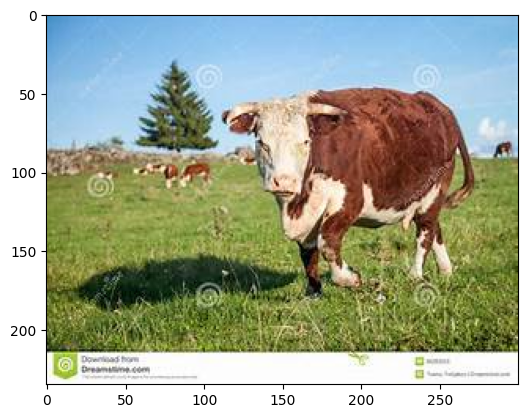

In [13]:
target = "cow"


path = os.path.join(train_dir, target)
files = os.listdir(path)
images = [file for file in files]
random_image = random.choice(images)
print(random_image)
image = mpimg.imread(os.path.join(path, random_image))
plt.imshow(image)
plt.show()
###

9865518.jpg


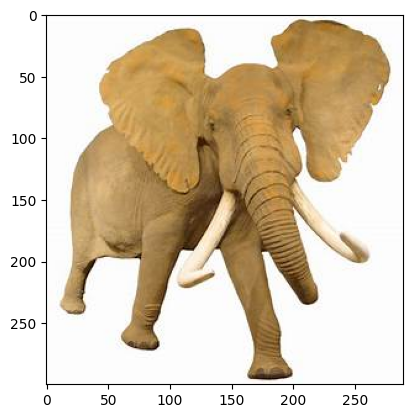

In [14]:
target = "elephant"


path = os.path.join(train_dir, target)
files = os.listdir(path)
images = [file for file in files]
random_image = random.choice(images)
print(random_image)
image = mpimg.imread(os.path.join(path, random_image))
plt.imshow(image)
plt.show()
###

4827172.jpg


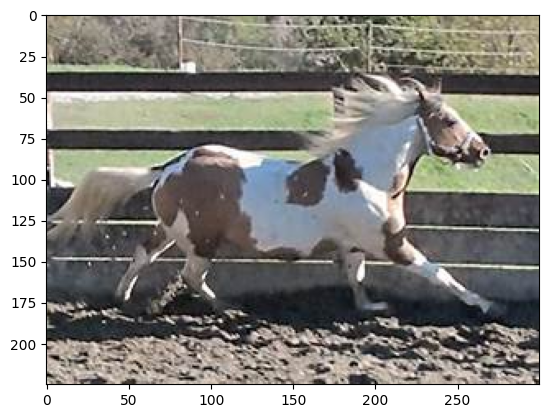

In [15]:
target = "horse"

path = os.path.join(train_dir, target)
files = os.listdir(path)
images = [file for file in files]
random_image = random.choice(images)
print(random_image)
image = mpimg.imread(os.path.join(path, random_image))
plt.imshow(image)
plt.show()
###

4218621.jpg


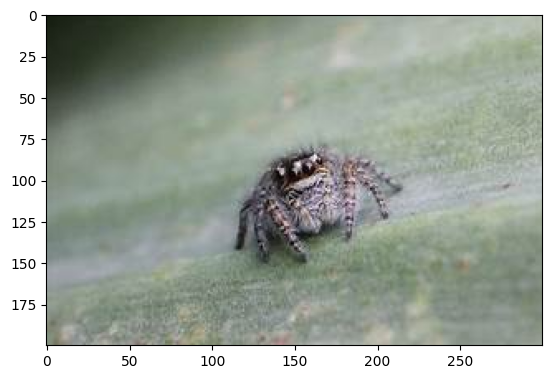

In [16]:
target = "spider"


path = os.path.join(train_dir, target)
files = os.listdir(path)
images = [file for file in files]
random_image = random.choice(images)
print(random_image)
image = mpimg.imread(os.path.join(path, random_image))
plt.imshow(image)
plt.show()
###

In [17]:

def data_augmentation_preprocess():
    rand_rotation = tf.keras.layers.RandomRotation(0.15, fill_mode='nearest')

    rand_flip_hor = tf.keras.layers.RandomFlip("horizontal")

    # Adjusted Random Zoom
    rand_zoom = tf.keras.layers.RandomZoom((-0.2, 0.2))

    # Added Brightness and Contrast Variation
    rand_brightness = tf.keras.layers.RandomBrightness(0.2)
    rand_contrast = tf.keras.layers.RandomContrast(0.2)
    
    rand_shear = tf.keras.layers.RandomRotation(0.2)  # Random shear
    rand_width_shift = tf.keras.layers.RandomWidth(0.2)  # Random width shift
    rand_height_shift = tf.keras.layers.RandomHeight(0.2)  # Random height shift

    data_augmentation_pipeline = tf.keras.Sequential(
        [
            rand_rotation,
            rand_flip_hor,
            rand_zoom,
            rand_brightness,
            rand_contrast,
            rand_shear,
            rand_width_shift,
            rand_height_shift
        ]
    )

    return data_augmentation_pipeline


In [18]:
def get_data(*, data_root, target_size=(224, 224), batch_size=32, data_augmentation=False):
    
    train_path = os.path.join(data_root, "Train")
    train_dataset = image_dataset_from_directory(
        train_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=True,
    )

    valid_path = os.path.join(data_root, "Valid")    
    valid_dataset = image_dataset_from_directory(
        valid_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=False, 
    )
    
    if data_augmentation: 
        data_augmentation_pipeline = data_augmentation_preprocess()
        train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
        #valid_dataset = valid_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
            
        
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)    
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, valid_dataset

### <font style="color:green">Training Configuration</font>

In [28]:
@dataclass
class TrainingConfig:
    
    # efficient utilization of the computational power of all the devices involved in training.
    BATCH_SIZE: int = 16 * DISTRIBUTE_STRATEGY.num_replicas_in_sync

    EPOCHS: int = 30
    LEARNING_RATE: float = 0.01

    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"

    # Use multiprocessing during training.
    use_multiprocessing: bool = True if platform.system() == "Linux" else False
        
    # Number of workers to use for training.
    num_workers: int = 4
        
    #print(BATCH_SIZE)

32


In [20]:
@dataclass
class DatasetConfig:
    DATA_ROOT: str = r"../input/opencv-TF-course-project-1-image-classification/dataset"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 4

In [21]:
def get_callbacks(
    training_config=TrainingConfig(),
    monitor="val_loss",
    mode="min",
    save_weights_only=False,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=20,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )

    
    checkpoint_filepath = training_config.checkpoint_dir
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(training_config.checkpoint_dir, "model.ckpt")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=0,
    )
    
    return [tensorboard_callback, model_checkpoint_callback]

In [22]:
def setup_log_directory(training_config=TrainingConfig()):
    '''Tensorboard Log and Model checkpoint directory Setup'''
    
    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory 
    training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(training_config.log_dir,        exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")
    
    return training_config, version_name

In [23]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Accuracy Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

In [24]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    GlobalAveragePooling2D,
    Rescaling,
)


def get_model(num_classes=4, input_shape=(224, 224, 3), name="Dummy_Model"):

    inputs = Input(shape=input_shape)
    
    rescaled = Rescaling(1./255)(inputs)
    
    conv1 = Conv2D(8, 3, activation="relu")(rescaled)
    bn1   = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(16, 3, activation="relu")(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(32, 3, activation="relu")(pool2)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
        
    conv4 = Conv2D(64, 3, activation="relu")(pool3)
    bn4 = BatchNormalization()(conv4)
    conv_out = MaxPooling2D(pool_size=(2, 2))(bn4)

    flatten = Flatten()(conv_out)
    output = Dense(num_classes, activation="softmax")(flatten)

    return Model(inputs=inputs, outputs=output, name=name)

In [25]:
def train_model(
    dataset_config=DatasetConfig(),
    training_config=TrainingConfig(),
    data_augmentation=True,
    print_summary=True,
):

    # Get training and validation datasets.
    train_dataset, valid_dataset = get_data(
        data_root=dataset_config.DATA_ROOT,
        target_size=dataset_config.DATA_SHAPE[:2],
        batch_size=training_config.BATCH_SIZE,
        data_augmentation=data_augmentation,
    )
    
    for images, labels in valid_dataset:
        print("X Shape:", images.shape, "Y Shape:", labels.shape)
        break
        

    # # Get model
    # model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

    # # Initialize optimizer
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)

    # # Compile model
    # model.compile(
    #     loss="categorical_crossentropy",
    #     optimizer=optimizer,
    #     metrics=["accuracy"],
    # )

    # Start a context manager using the distributed strategy previously defined.
    # This scope ensures that the operations defined within it are distributed across the available devices as per the strategy.
    with DISTRIBUTE_STRATEGY.scope():
        # Get the model by calling the 'get_model' function.
        model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

        # Compile the model. This step configures the model for training.
        # 'loss' is set to 'categorical_crossentropy', which is a common choice for classification tasks.
        # 'optimizer' is an Adam optimizer with a specific learning rate from the training configuration.
        # 'metrics' is a list of metrics to be evaluated by the model during training and testing, here it's set to track 'accuracy'.
        model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
            metrics=["accuracy"],
        )


    # Print model summary
    if print_summary:
        model.summary()

    # Get training callbacks
    callbacks = get_callbacks(training_config)

    # Train model
    training_results = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=training_config.EPOCHS,
        callbacks=callbacks,
        workers=training_config.num_workers,
        use_multiprocessing=training_config.use_multiprocessing
    )

    print("training_results keys:", training_results.history.keys())

    return model, training_results

In [26]:
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(training_config)

Logging at: Logs_Checkpoints/Model_logs/version_0
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_0


In [ ]:
# Start training

trained_model, training_results = train_model(
    dataset_config=DatasetConfig(),
    training_config=training_config,
    data_augmentation=True,
)

In [ ]:
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

In [ ]:
def recreate_model(path, load_weights=False, config=DatasetConfig(), **kwargs):
    """
    For reloading trained model
    Args:
        path: current_version checkpoint path
        load_weights: Whether the files saved at path contains model weights
                      or the Entire model configuration
        **kwargs: use to pass additional keyword arguments to the load_model method
    Returns:
        Reinitialized Trained Model
    """

    if load_weights:
        
        # Create model architecture
        model = get_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)

        # Load trained model best weights.
        path = os.path.join(path, "model.ckpt")
        model.load_weights(path).expect_partial()
    else:
        model = tf.keras.models.load_model(path, **kwargs)

    model.summary()
    return model

In [ ]:
# Loading trained model

load_version = current_version_name
checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version) 

trained_model = recreate_model(checkpoint_path)

In [ ]:
def get_sample_predictions(*, model, dataset, total=15):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
    
        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)
        
        # Displaying only 15 images 
        if data.shape[0] >= total: 
            break

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (18, 9)
    fig = plt.figure()
    fig.set_facecolor("white")

    for idx in range(total):

        plt.subplot(3, 5, idx + 1)
        img = imgs[idx]
        plt.imshow(img)

        plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
        plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    del imgs, ground_truths, probs, predictions
    return

In [ ]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "Valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    label_mode='int',
    color_mode='rgb', 
    batch_size=training_config.BATCH_SIZE, 
    image_size=data_config.DATA_SHAPE[:2], 
    shuffle=True, # shuffling to show images from all classes
)

get_sample_predictions(model=trained_model, dataset=valid_dataset)

In [ ]:

def get_incorrect_sample_predictions(*, model, dataset, total=10):
    imgs = []
    ground_truths = []
    probs = []
    predictions = []
    wrong_count = 0
    
    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Predictions...")
    
    for data, target in dataset:        
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
        
        for i in range(len(cls_predicted)):  # Iterate through each instance in the batch
            if cls_predicted[i] != target[i]:
                imgs.append(data[i].numpy() / 255.)
                ground_truths.append(target[i].numpy())
                predictions.append(cls_predicted[i])
                probs.append(cls_probs[i])
                wrong_count += 1

                if wrong_count == total:  # Break if enough incorrect samples are found
                    break
            
        # Displaying only 10 images 
        if wrong_count == total:
            break

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (18, 9)
    fig = plt.figure()
    fig.set_facecolor("white")

    for idx in range(total):

        plt.subplot(3, 5, idx + 1)
        img = imgs[idx]
        plt.imshow(img)

        plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
        plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    del imgs, ground_truths, probs, predictions
    return
###

In [ ]:
get_incorrect_sample_predictions(model=trained_model, dataset=valid_dataset)